# Case Study 1: Quora Question Pair Similarity

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

### 1. Preparing the train and test data

In [150]:
# This CSV contains 1 id feature + 1 class label + 11 simple features + 15 advancedfeatures + question1 + question2 = 30 features
# This csv has been extracted from '3.Q_Mean_W2V.ipynb' notebook

'''
dfmerged = df1.merge(df2, on='id',how='left')
new_df = df[['id','question1','question2']]
dfmerged = dfmerged.merge(new_df, on='id',how='left')
dfmerged.to_csv('features_without_tfidf.csv', index=False)
'''

df = pd.read_csv("features_without_tfidf.csv")
print("Shape of the data is", df.shape)
df.head(5)

Shape of the data is (404290, 30)


,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,question1,question2
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,...,57,14,12,10.0,23.0,0.434783,2,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,...,88,8,13,4.0,20.0,0.200000,5,3,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,...,59,14,10,4.0,24.0,0.166667,2,0,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,65,11,9,0.0,19.0,0.000000,2,0,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,...,39,13,7,2.0,20.0,0.100000,4,2,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?


In [151]:
df['all_questions'] = df.question1 + ' ' + df.question2
df.all_questions[0]

'What is the step by step guide to invest in share market in india? What is the step by step guide to invest in share market?'

In [153]:
# splitting the data into train and test before vectorizing
from sklearn.model_selection import train_test_split

#all_q = df['all_questions']

isduplicate = df['is_duplicate']
X = df.drop(['is_duplicate', 'id', 'question1', 'question2'], axis=1)[0:100000]
Y = np.array(isduplicate[0:100000])
#Y = df['is_duplicate'][0:5000]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=3)

print("Size of training data is", x_train.shape)
print("Size of test data is", x_test.shape)

Size of training data is (75000, 27)
Size of test data is (25000, 27)


In [154]:
#questions_train = list(x_train['question1']) + list(x_train['question2'])
#questions_test = list(x_test['question1']) + list(x_test['question2'])

x_train_ques = x_train['all_questions']
x_test_ques = x_test['all_questions']

x_train = x_train.drop(['all_questions'], axis=1)
x_test = x_test.drop(['all_questions'], axis=1)

tfidf = TfidfVectorizer(ngram_range=(1,3),min_df=10)
tfidf.fit(x_train_ques)

x_train_tfidf = tfidf.transform(x_train_ques)
x_test_tfidf = tfidf.transform(x_test_ques)

print("Shape of train and test data after vectorization are:")
print("Train Data", x_train_tfidf.shape)
print("Test Data", x_test_tfidf.shape)

Shape of train and test data after vectorization are:
Train Data (75000, 31366)
Test Data (25000, 31366)


In [155]:
# Adding the tfidf features into the the main training and test data
from scipy.sparse import hstack

x_train = hstack((x_train.astype(float), x_train_tfidf))
x_test = hstack((x_test.astype(float), x_test_tfidf))

print("New shapes of training and test data is")
print(x_train.shape)
print(x_test.shape)

New shapes of training and test data is
(75000, 31392)
(25000, 31392)


In [156]:
type(x_train)

scipy.sparse.coo.coo_matrix

### 1.1 Preparing data for XGBoost model, vectorizing the data by tfidf-w2v

In [205]:
dfw2v = pd.read_csv(r"C:\Users\momoarif\Downloads\AppliedAICourse\Case Studies\01_Quora_Question_Pair_Similarity\train.csv")
dfw2v['question1'] = dfw2v['question1'].apply(lambda x: str(x))
dfw2v['question2'] = dfw2v['question2'].apply(lambda x: str(x))
df.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,question1,question2,all_questions
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,...,14,12,10.0,23.0,0.434783,2,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,...,8,13,4.0,20.0,0.200000,5,3,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,What is the story of Kohinoor (Koh-i-Noor) Dia...
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,...,14,10,4.0,24.0,0.166667,2,0,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,How can I increase the speed of my internet co...
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,11,9,0.0,19.0,0.000000,2,0,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,Why am I mentally very lonely? How can I solve...
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,...,13,7,2.0,20.0,0.100000,4,2,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,"Which one dissolve in water quikly sugar, salt..."


### 2. Applying ML Models - Logistic Regression

In [157]:
# Some functions

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [158]:
# Finding best C using GridSearchCV method with 5-fold CV option
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr_tfidf = LogisticRegression(penalty='l2')
parameters = [{'C':[10**-4, 10**-3, 10**-2, 10**-1, 1.0, 10**2, 10**3, 10**4]}]
clf = GridSearchCV(lr_tfidf, parameters, cv=5, scoring='roc_auc', return_train_score=True)
clf.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 100, 1000,
                                10000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

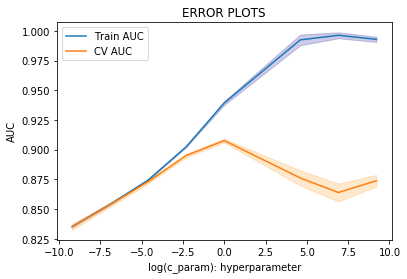

Best Estimator: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Best Parameter: {'C': 1.0}
Test Score: 0.9077031520952366


In [159]:
# Finding AUC for train and CV data set
# these AUC's will be used to plot against the lambda/C hyperparameter to get the best value

train_auc = clf.cv_results_['mean_train_score']
train_auc_std = clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std = clf.cv_results_['std_test_score']

c_param = [10**-4, 10**-3, 10**-2, 10**-1, 1.0, 10**2, 10**3, 10**4]

# Plotting train AUC and CV AUC versus log of C
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.plot(np.log(c_param), train_auc, label='Train AUC')
plt.gca().fill_between(np.log(c_param), train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(c_param), cv_auc, label='CV AUC')
plt.gca().fill_between(np.log(c_param), cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.legend()
plt.xlabel("log(c_param): hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("Best Estimator:", clf.best_estimator_)
print("Best Parameter:", clf.best_params_)
print("Test Score:", clf.score(x_test, y_test))

print('='*100)

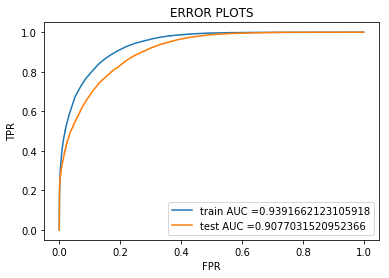

The best alpha 1.0 has a train log loss value :0.31404310407464303
The best alpha 1.0 has a test log loss value :0.3673161773580128
Total number of data points : 25000


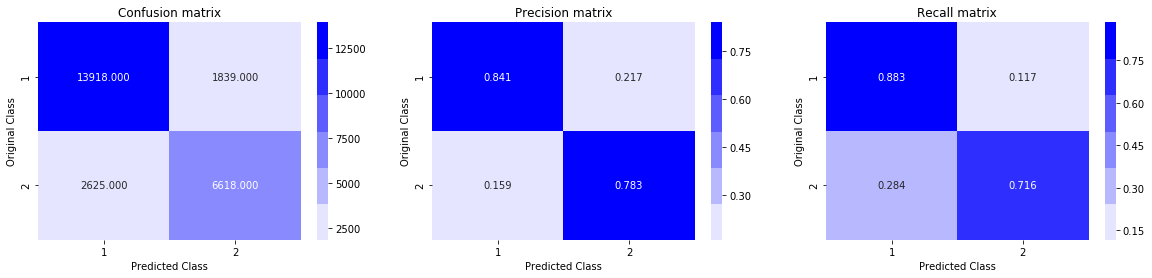

In [160]:
# Training out tfidf train vectors with the best hyperparameter value
from sklearn.metrics import roc_curve, auc
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix
import seaborn as sns

best_c = 1.0

lr_l2 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
lr_l2.fit(x_train, y_train)

train_fpr, train_tpr, thresholds = roc_curve(y_train, lr_l2.predict_proba(x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr_l2.predict_proba(x_test)[:,1])

# Plotting the error plots (false positive and total positive) against alpha hyperparameter
# for both train and test data
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

# displaying log loss values for train and test data
y_pred_tr = lr_l2.predict_proba(x_train)
print("The best alpha {} has a train log loss value :{}".format(best_c, log_loss(y_train, y_pred_tr, labels=lr_l2.classes_, eps=1e-15)))

y_pred_ts = lr_l2.predict_proba(x_test)
print("The best alpha {} has a test log loss value :{}".format(best_c, log_loss(y_test, y_pred_ts, labels=lr_l2.classes_, eps=1e-15)))

# plotting confusion, precision and recall matrixs
predicted_y =np.argmax(y_pred_ts, axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### 3. Applying ML Models - Linear SVM

In [161]:
# Training linear SVM on training data
from sklearn.linear_model import SGDClassifier

lr_svm = SGDClassifier(loss='hinge', penalty='l2')

parameters = [{'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 1.0, 10**2, 10**3, 10**4]}]
clf = GridSearchCV(lr_svm, parameters, cv=5, scoring='roc_auc', return_train_score=True)
clf.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 100, 1000,
                                    10000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,


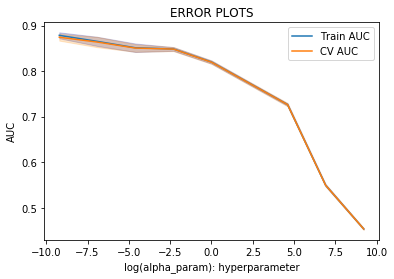

Best Estimator for l1: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Best Parameter for l1: {'alpha': 0.0001}
Test Score for l1: 0.877219998240754


In [162]:
# Finding AUC for train and CV data set
# these AUC's will be used to plot against the lambda/C hyperparameter to get the best value

train_auc = clf.cv_results_['mean_train_score']
train_auc_std = clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std = clf.cv_results_['std_test_score']

alpha_param = [10**-4, 10**-3, 10**-2, 10**-1, 1.0, 10**2, 10**3, 10**4]

# Plotting train AUC and CV AUC versus log of C
plt.plot(np.log(alpha_param), train_auc, label='Train AUC')
plt.gca().fill_between(np.log(alpha_param), train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(alpha_param), cv_auc, label='CV AUC')
plt.gca().fill_between(np.log(alpha_param), cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.legend()
plt.xlabel("log(alpha_param): hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


print("Best Estimator for l1:", clf.best_estimator_)
print("Best Parameter for l1:", clf.best_params_)
print("Test Score for l1:", clf.score(x_test, y_test))

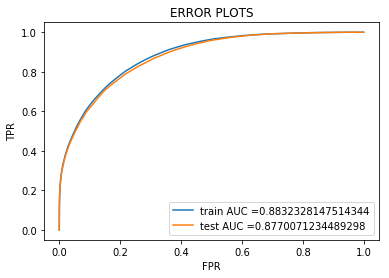

The best alpha 0.0001 has a train hinge loss value :0.8904133333333333
The best alpha 0.0001 has a test hinge loss value :0.89188


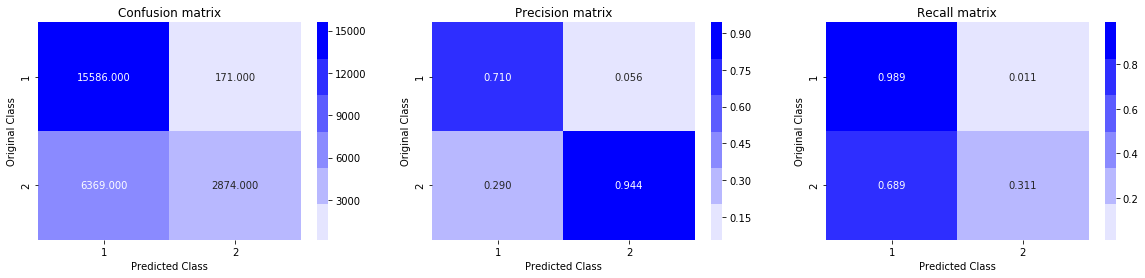

In [163]:
# Training out tfidf train vectors using linear svm with best alpha value
from sklearn.calibration import CalibratedClassifierCV

best_alpha = 0.0001
lr_svm = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
lr_svm.fit(x_train, y_train)

clf_calibrated = CalibratedClassifierCV(clf, cv='prefit', method='isotonic')
clf_calibrated.fit(x_train, y_train)
#y_train_pred = clf_calibrated.predict_proba(x_train)
#y_test_pred = clf_calibrated.predict_proba(x_test)
#print(y_test_pred)

train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_calibrated.predict_proba(x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_calibrated.predict_proba(x_test)[:,1])

# Plotting the error plots (false positive and total positive) against alpha hyperparameter
# for both train and test data
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

# displaying log loss values for train and test data
from sklearn.metrics import hinge_loss

y_pred_tr = lr_svm.predict(x_train)
print("The best alpha {} has a train hinge loss value :{}".format(best_alpha, hinge_loss(y_train, y_pred_tr, labels=lr_svm.classes_)))

y_pred_ts = lr_svm.predict(x_test)
print("The best alpha {} has a test hinge loss value :{}".format(best_alpha, hinge_loss(y_test, y_pred_ts, labels=lr_svm.classes_)))

# plotting confusion, precision and recall matrixs
#predicted_y = np.argmax(y_pred_ts, axis=1)
#print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, y_pred_ts)

### 4. Applying ML Models - XGBoost on TFIDF W2V

In [40]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [4]:
df_train = pd.read_csv("final_features_train.csv")
df_train.shape

(404290, 221)

In [6]:
df_train_clean = df_train.dropna()

In [7]:
df_test = pd.read_csv("final_features_test.csv")
df_test.shape

(404290, 221)

In [8]:
df_test_clean = df_test.dropna()

In [12]:
print("New shape of training feature after cleaning is", df_train_clean.shape)
print("New shape of test feature after cleaning is", df_test_clean.shape)

New shape of training feature after cleaning is (303217, 221)
New shape of test feature after cleaning is (101073, 221)


In [13]:
df_train_clean.to_csv('final_features_train_final.csv')
df_test_clean.to_csv('final_features_test_final.csv')

In [15]:
#Creating db file from csv, each for training and test
from sqlalchemy import create_engine
import datetime as dt

if not os.path.isfile('db_train.db'):
    disk_engine = create_engine('sqlite:///db_train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('final_features_train_final.csv', names=['Unnamed: 0','Unnamed: 1','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','96_x','97_x','98_x','99_x','100_x','101_x','102_x','103_x','104_x','105_x','106_x','107_x','108_x','109_x','110_x','111_x','112_x','113_x','114_x','115_x','116_x','117_x','118_x','119_x','120_x','121_x','122_x','123_x','124_x','125_x','126_x','127_x','128_x','129_x','130_x','131_x','132_x','133_x','134_x','135_x','136_x','137_x','138_x','139_x','140_x','141_x','142_x','143_x','144_x','145_x','146_x','147_x','148_x','149_x','150_x','151_x','152_x','153_x','154_x','155_x','156_x','157_x','158_x','159_x','160_x','161_x','162_x','163_x','164_x','165_x','166_x','167_x','168_x','169_x','170_x','171_x','172_x','173_x','174_x','175_x','176_x','177_x','178_x','179_x','180_x','181_x','182_x','183_x','184_x','185_x','186_x','187_x','188_x','189_x','190_x','191_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y','96_y','97_y','98_y','99_y','100_y','101_y','102_y','103_y','104_y','105_y','106_y','107_y','108_y','109_y','110_y','111_y','112_y','113_y','114_y','115_y','116_y','117_y','118_y','119_y','120_y','121_y','122_y','123_y','124_y','125_y','126_y','127_y','128_y','129_y','130_y','131_y','132_y','133_y','134_y','135_y','136_y','137_y','138_y','139_y','140_y','141_y','142_y','143_y','144_y','145_y','146_y','147_y','148_y','149_y','150_y','151_y','152_y','153_y','154_y','155_y','156_y','157_y','158_y','159_y','160_y','161_y','162_y','163_y','164_y','165_y','166_y','167_y','168_y','169_y','170_y','171_y','172_y','173_y','174_y','175_y','176_y','177_y','178_y','179_y','180_y','181_y','182_y','183_y','184_y','185_y','186_y','187_y','188_y','189_y','190_y','191_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data_train', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

180000 rows
360000 rows


In [16]:
#Creating db file from csv, each for training and test
if not os.path.isfile('db_test.db'):
    disk_engine = create_engine('sqlite:///db_test.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('final_features_test_final.csv', names=['Unnamed: 0','Unnamed: 1','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','96_x','97_x','98_x','99_x','100_x','101_x','102_x','103_x','104_x','105_x','106_x','107_x','108_x','109_x','110_x','111_x','112_x','113_x','114_x','115_x','116_x','117_x','118_x','119_x','120_x','121_x','122_x','123_x','124_x','125_x','126_x','127_x','128_x','129_x','130_x','131_x','132_x','133_x','134_x','135_x','136_x','137_x','138_x','139_x','140_x','141_x','142_x','143_x','144_x','145_x','146_x','147_x','148_x','149_x','150_x','151_x','152_x','153_x','154_x','155_x','156_x','157_x','158_x','159_x','160_x','161_x','162_x','163_x','164_x','165_x','166_x','167_x','168_x','169_x','170_x','171_x','172_x','173_x','174_x','175_x','176_x','177_x','178_x','179_x','180_x','181_x','182_x','183_x','184_x','185_x','186_x','187_x','188_x','189_x','190_x','191_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y','96_y','97_y','98_y','99_y','100_y','101_y','102_y','103_y','104_y','105_y','106_y','107_y','108_y','109_y','110_y','111_y','112_y','113_y','114_y','115_y','116_y','117_y','118_y','119_y','120_y','121_y','122_y','123_y','124_y','125_y','126_y','127_y','128_y','129_y','130_y','131_y','132_y','133_y','134_y','135_y','136_y','137_y','138_y','139_y','140_y','141_y','142_y','143_y','144_y','145_y','146_y','147_y','148_y','149_y','150_y','151_y','152_y','153_y','154_y','155_y','156_y','157_y','158_y','159_y','160_y','161_y','162_y','163_y','164_y','165_y','166_y','167_y','168_y','169_y','170_y','171_y','172_y','173_y','174_y','175_y','176_y','177_y','178_y','179_y','180_y','181_y','182_y','183_y','184_y','185_y','186_y','187_y','188_y','189_y','190_y','191_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data_test', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

180000 rows


In [17]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = sqlite3.connect(db_file)
    return conn
 
    return None

def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the database:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [22]:
import sqlite3
read_train_db = 'db_train.db'
conn_train = create_connection(read_train_db)
checkTableExists(conn_train)
conn_train.close()

Tables in the database:
data_train


In [23]:
read_test_db = 'db_test.db'
conn_test = create_connection(read_test_db)
checkTableExists(conn_test)
conn_test.close()

Tables in the database:
data_test


In [25]:
if os.path.isfile(read_train_db):
    conn_train = create_connection(read_train_db)
    if conn_train is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
        # for selecting random points
        data_train = pd.read_sql_query("SELECT * From data_train ORDER BY RANDOM() LIMIT 30000;", conn_train)
        conn_train.commit()
        conn_train.close()
data_bkp = data_train

In [26]:
if os.path.isfile(read_test_db):
    conn_test = create_connection(read_test_db)
    if conn_test is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
        # for selecting random points
        data_test = pd.read_sql_query("SELECT * From data_test ORDER BY RANDOM() LIMIT 10000;", conn_test)
        conn_test.commit()
        conn_test.close()
data_bkp = data_test

In [27]:
data_train.shape

(30000, 415)

In [28]:
data_test.shape

(10000, 415)

In [29]:
# remove the first row 
data_train.drop(data_train.index[0], inplace=True)
data_test.drop(data_test.index[0], inplace=True)

y_true_train = data_train['is_duplicate']
y_true_test = data_test['is_duplicate']

data_train.drop(['Unnamed: 0','Unnamed: 1', 'id','index','is_duplicate'], axis=1, inplace=True)
data_test.drop(['Unnamed: 0','Unnamed: 1', 'id','index','is_duplicate'], axis=1, inplace=True)


# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols_tr = list(data_train.columns)
cols_ts = list(data_test.columns)

for i in cols_tr:
    data_train[i] = data_train[i].apply(pd.to_numeric)
    #print(i)
for i in cols_ts:
    data_test[i] = data_test[i].apply(pd.to_numeric)

In [30]:
y_true_train = list(map(int, y_true_train.values))
y_true_test = list(map(int, y_true_test.values))

In [32]:
# Splitting data into train and test
# We don't need this now, because since tfidf w2v, out train and test data was separated.

#x_train_tfidfw2v, x_test_tfidfw2v, y_train_tfidfw2v, y_test_tfidfw2v = train_test_split(data, y_true, stratify=y_true, test_size=0.25)

x_train_tfidfw2v = data_train
x_test_tfidfw2v = data_test
y_train_tfidfw2v = y_true_train
y_test_tfidfw2v = y_true_test


print("Number of data points in train data :",x_train_tfidfw2v.shape)
print("Number of data points in test data :",x_test_tfidfw2v.shape)

Number of data points in train data : (29999, 410)
Number of data points in test data : (9999, 410)


In [37]:
import xgboost as xgb
from sklearn.metrics.classification import accuracy_score, log_loss

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train_tfidfw2v, label=y_train_tfidfw2v)
d_test = xgb.DMatrix(x_test_tfidfw2v, label=y_test_tfidfw2v)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(x_train_tfidfw2v, y_train_tfidfw2v)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test_tfidfw2v, predict_y, eps=1e-15))

[0]	train-logloss:0.684869	valid-logloss:0.685053
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.61558	valid-logloss:0.617495
[20]	train-logloss:0.56403	valid-logloss:0.567471
[30]	train-logloss:0.525434	valid-logloss:0.530297
[40]	train-logloss:0.496085	valid-logloss:0.502171
[50]	train-logloss:0.472748	valid-logloss:0.4798
[60]	train-logloss:0.454648	valid-logloss:0.462981
[70]	train-logloss:0.439929	valid-logloss:0.449138
[80]	train-logloss:0.427974	valid-logloss:0.437936
[90]	train-logloss:0.418034	valid-logloss:0.4287
[100]	train-logloss:0.409815	valid-logloss:0.421251
[110]	train-logloss:0.402828	valid-logloss:0.414779
[120]	train-logloss:0.396938	valid-logloss:0.409445
[130]	train-logloss:0.392045	valid-logloss:0.405116
[140]	train-logloss:0.387746	valid-logloss:0.401412
[150]	train-logloss:0.384037	valid-logloss:0.398239
[160]	train-logloss:0.380861	valid

Total number of data points : 9999


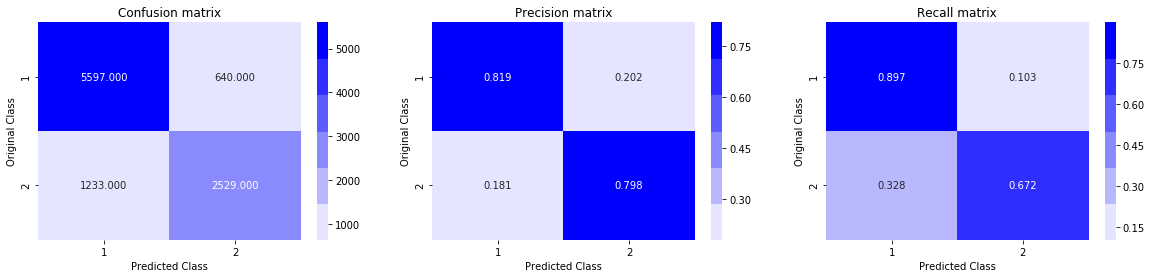

In [44]:
from sklearn.metrics import confusion_matrix
predicted_y = np.array(predict_y > 0.5, dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test_tfidfw2v, predicted_y)

### 5. Applying ML Models - Hyperparameter Tuning of XGBoost using RandomSearch

In [45]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Parameters for XGBoost: parameter values and data volume reduced to reduce time consumption
param = {'n_estimators':[100,200,400,600], 'max_depth':[7,8,10,12]}
xgboostclf = xgb.XGBClassifier()

print("Shapes of training and test data for hyperparameter tuning is {} and {}".format(x_train_tfidfw2v.shape, x_test_tfidfw2v.shape))

clf = RandomizedSearchCV(xgboostclf, param_distributions=param, cv=3, scoring='roc_auc', return_train_score=True)
clf.fit(x_train_tfidfw2v, y_train_tfidfw2v)
clf.best_params_

Shapes of training and test data for hyperparameter tuning is (29999, 410) and (9999, 410)


{'n_estimators': 600, 'max_depth': 12}

The training log loss using the best parameters {'n_estimators': 600, 'max_depth': 12} is 0.0023194627413459447
The test log loss using the best parameters {'n_estimators': 600, 'max_depth': 12} is 0.46089345961445616


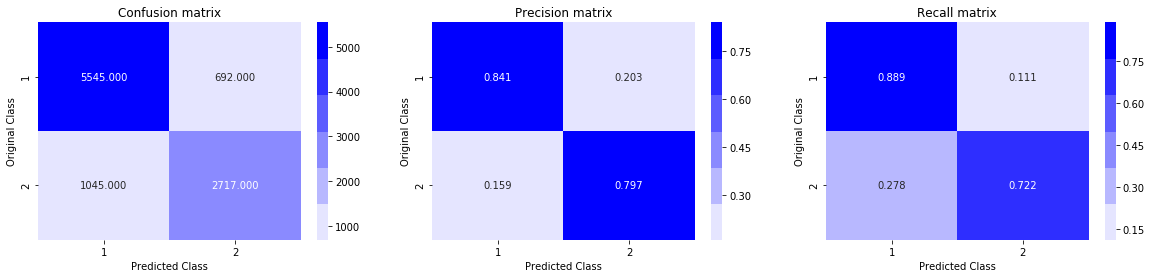

In [46]:
# Training with the best parameters obtained after applying random search CV
xgboostclf = xgb.XGBClassifier(n_estimators=600, max_depth=12)
xgboostclf.fit(x_train_tfidfw2v, y_train_tfidfw2v)

# Calculating train and test losses
y_pred_tr=xgboostclf.predict_proba(x_train_tfidfw2v)
y_pred_ts=xgboostclf.predict_proba(x_test_tfidfw2v)

print("The training log loss using the best parameters {} is {}".format(clf.best_params_, log_loss(y_train_tfidfw2v, y_pred_tr, eps=1e-15)))
print("The test log loss using the best parameters {} is {}".format(clf.best_params_, log_loss(y_test_tfidfw2v, y_pred_ts, eps=1e-15)))

# Displaying confusion, precision and recall matrix
predicted_y = np.argmax(y_pred_ts, axis=1)
plot_confusion_matrix(y_test_tfidfw2v, predicted_y)

### 6. Displaying the results using pretty table

In [47]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Algorithm", "#Datapoints", "Vectorizer", "Loss Type", "Train loss", "Test loss"]

x.add_row(["Logistic Regression","100000","TFIDF","Log loss","0.3140","0.3673"])
x.add_row(["Linear SVM","100000","TFIDF","Hinge loss","0.8904","0.8918"])
x.add_row(["XGBoost","40000","TFIDF","Log loss","0.3380","0.3690"])
x.add_row(["XGBoost (Hyperparameter tuning)","40000","TFIDF","Log loss","0.0023","0.4608"])

print(x.get_string(title="Models Comparison of Quora Question Pairs Similarity Problem"))

+--------------------------------------------------------------------------------------------------+
|                   Models Comparison of Quora Question Pairs Similarity Problem                   |
+---------------------------------+-------------+------------+------------+------------+-----------+
|            Algorithm            | #Datapoints | Vectorizer | Loss Type  | Train loss | Test loss |
+---------------------------------+-------------+------------+------------+------------+-----------+
|       Logistic Regression       |    100000   |   TFIDF    |  Log loss  |   0.3140   |   0.3673  |
|            Linear SVM           |    100000   |   TFIDF    | Hinge loss |   0.8904   |   0.8918  |
|             XGBoost             |    40000    |   TFIDF    |  Log loss  |   0.3380   |   0.3690  |
| XGBoost (Hyperparameter tuning) |    40000    |   TFIDF    |  Log loss  |   0.0023   |   0.4608  |
+---------------------------------+-------------+------------+------------+------------+---

## Observations

1. XGBoost model took bery long time to train but resulted in very good training log loss value but the test log loss went crazy. This indicates the model is highly overfitting
2. Because of the high training time, the number of data points was reduced from 100k to 40k
3. Linear SVM didn't performed well as compared to other models and has a disappointing hinge loss value